In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import yfinance as yf
import requests
from scipy.stats import skew, kurtosis
import statsmodels.api as sm


**Question 1.** Write a code which retrieves the last 5 years of Direxion data
 prices, thanks to the Yahoo API. This code should be written in such way that
 it could easily be executed later in the future.

In [2]:
#This cell does not work but had a goal to retrieve the data directly from Yahoo Finance and save it in the data variable. 
data = yf.download(
    tickers="SPXS SPY SPXL",  
    period="5y",               
    interval="1d",             
    group_by='ticker',         
    auto_adjust=True           
)

NameError: name 'yf' is not defined

In [71]:
#We retrieved the data on yukali's website. We download it for the project. The data range from 31/12/2010 to 02/04/2025.

data_funds = pd.read_csv('project_raw_data.csv')
data_funds=data_funds.set_index(pd.to_datetime(data_funds['ref_date'])).drop(columns=['ref_date'])


**Question 2.** The bank account Bt will be proxied by the SOFR Index. Retrieve the SOFR Index historical values thanks to the Federal Reserve of New York API.

In [74]:
# URL of the API of the network
url = 'https://markets.newyorkfed.org/api/rates/secured/sofrai/search.json?startDate=2020-04-02&endDate=2025-04-02'

#We launch a request thanks to the library 'requests'
response = requests.get(url)

# We also make a check to know if the request succeeded
if response.status_code == 200:
    #Request into Dictionnary and then into DataFrame 
    data = response.json()
    df_SOFR1 = pd.json_normalize(data['refRates'])
    df_SOFR1['effectiveDate'] = pd.to_datetime(df_SOFR1['effectiveDate'])
    df_SOFR1.set_index('effectiveDate', inplace=True)
    df_SOFR=df_SOFR1.iloc[::-1]
else:
    print(f"Erreur lors de la récupération des données : {response.status_code}")
df_SOFR


,type,average30day,average90day,average180day,index,revisionIndicator
effectiveDate,,,,,,
2020-04-02,SOFRAI,0.54444,1.22805,1.44345,1.041368,
2020-04-03,SOFRAI,0.49009,1.21089,1.43333,1.041369,
2020-04-06,SOFRAI,0.37605,1.15941,1.40272,1.041370,
2020-04-07,SOFRAI,0.33971,1.14213,1.39243,1.041370,
2020-04-08,SOFRAI,0.30336,1.12498,1.38214,1.041370,
...,...,...,...,...,...,...
2025-03-27,SOFRAI,4.33467,4.35860,4.56168,1.187023,
2025-03-28,SOFRAI,4.33568,4.35749,4.55895,1.187167,
2025-03-31,SOFRAI,4.33365,4.35445,4.54855,1.187596,


**Question 3.** Plot the historical plots of prices of the different products expressed in bank account units (i.e. Vt/Bt while rebasing them at 1 as their initial value).

In [80]:
# Ensure datetime index for safe filtering and slicing
df_SOFR.index = pd.to_datetime(df_SOFR.index)
data_funds.index = pd.to_datetime(data_funds.index)

# Reference date for rebasing
date_ref = pd.to_datetime('2020-04-02')

# Safely extract initial SOFR index value
try:
    Index_0 = df_SOFR.loc[df_SOFR.index == date_ref, 'index'].iloc[0]
except IndexError:
    raise ValueError("Reference date not found in df_SOFR.")

# Utility function to get initial price of a given ticker on reference date
def get_initial_price(df, ticker, date, column='price_close'):
    try:
        return df.loc[(df.index == date) & (df['ticker'] == ticker), column].iloc[0]
    except IndexError:
        raise ValueError(f"Initial price for {ticker} not found on {date}.")

# Get initial closing prices for each fund
SPXL_0 = get_initial_price(data_funds, 'SPXL', date_ref)
SPXS_0 = get_initial_price(data_funds, 'SPXS', date_ref)
SPY_0  = get_initial_price(data_funds, 'SPY',  date_ref)

# Filter SOFR data after the reference date
df_SOFR_filtered = df_SOFR[df_SOFR.index > date_ref][['index']].copy()
returns = df_SOFR_filtered.copy()

# Add price data for each ETF to the returns DataFrame
for ticker in ['SPXL', 'SPY', 'SPXS']:
    temp = data_funds[
        (data_funds.index > date_ref) & 
        (data_funds['ticker'] == ticker)
    ][['price_close']].rename(columns={'price_close': f'price_{ticker}'})
    
    returns = returns.merge(temp, left_index=True, right_index=True, how='inner')

# Compute normalized and SOFR-adjusted performance for each asset
returns['perf_SOFR'] = returns['index'] / Index_0
returns['perf_SPXL'] = (returns['price_SPXL'] / SPXL_0) / returns['perf_SOFR']
returns['perf_SPY']  = (returns['price_SPY']  / SPY_0 ) / returns['perf_SOFR']
returns['perf_SPXS'] = (returns['price_SPXS'] / SPXS_0) / returns['perf_SOFR']

returns

,index,price_SPXL,price_SPY,price_SPXS,perf_SOFR,perf_SPXL,perf_SPY,perf_SPXS
2020-04-03,1.041369,23.110001,248.190002,175.500000,1.000000,0.958126,0.985546,1.042161
2020-04-06,1.041370,27.790001,264.859985,140.000000,1.000001,1.152155,1.051740,0.831353
2020-04-07,1.041370,27.780001,265.130005,139.500000,1.000001,1.151740,1.052812,0.828384
2020-04-08,1.041370,30.610001,274.029999,125.199997,1.000002,1.269069,1.088153,0.743467
2020-04-09,1.041371,31.980000,278.200012,119.300003,1.000002,1.325868,1.104711,0.708431
...,...,...,...,...,...,...,...,...
2025-03-27,1.187023,146.800003,567.080017,6.820000,1.139868,5.339420,1.975523,0.035529
2025-03-28,1.187167,137.929993,555.659973,7.250000,1.140006,5.016192,1.935505,0.037765
2025-03-31,1.187596,140.389999,559.390015,7.120000,1.140419,5.103810,1.947794,0.037074
2025-04-01,1.187742,141.710007,560.969971,7.050000,1.140558,5.151168,1.953056,0.036705


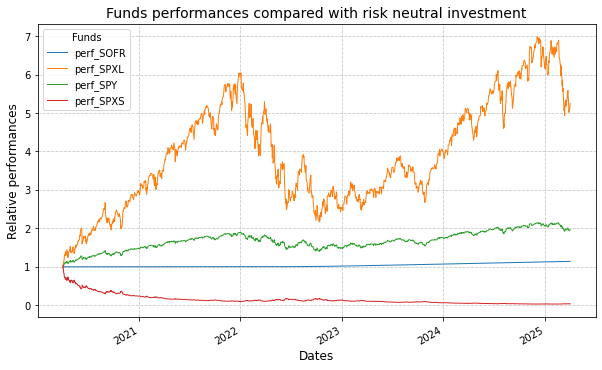

In [76]:
# We select columns to plot
col_plot = ['perf_SOFR','perf_SPXL','perf_SPY','perf_SPXS']

# Graph creation
ax = returns.plot(          
    y=col_plot,        
    style='-',  
    linewidth=1,
    figsize=(10, 6)
)

# Personnalisation
ax.set_title('Funds performances compared with risk neutral investment', fontsize=14)
ax.set_xlabel('Dates', fontsize=12)
ax.set_ylabel('Relative performances', fontsize=12)
ax.legend(title='Funds', loc='upper left')  # Position personnalisée de la légende
plt.grid(linestyle='--', alpha=0.7)
plt.show()


**Question 4.** Compute the following (annualized) descriptive statistics of daily
 log-returns: mean, volatility, skewness, kurtosis. Compute their correlations as
 well as their Sharpe ratio. Comment.

In [77]:
# Ensure index is datetime
df_SOFR.index = pd.to_datetime(df_SOFR.index)

# Define start date for calculation
start_date = pd.to_datetime("2020-04-02")

# Filter data starting from the start date
filtered_df = df_SOFR[df_SOFR.index >= start_date]

# Get initial and final values of the SOFR index
initial_value = filtered_df["index"].iloc[0]
final_value   = filtered_df["index"].iloc[-1]

# Compute total return
total_return = (final_value - initial_value) / initial_value

# Compute number of days between start and end (ACT/360 basis)
num_days = (filtered_df.index[-1] - filtered_df.index[0]).days
annualized_sofr = total_return * (360 / num_days)

print(f"\nSOFR Index Total Return: {total_return * 100:.2f}%")
print(f"SOFR Annualized Return (Linear, ACT/360): {annualized_sofr * 100:.2f}%")
#print(final_value, initial_value)


SOFR Index Total Return: 14.07%
SOFR Annualized Return (Linear, ACT/360): 2.77%


In [82]:
# Second, using the daily log-returns, we compute annualized log-returns,  mean, volatility, skewness, kurtosis,
# the correlations of the ETFs, as well as their Sharpe ratio

# Calculate daily log returns for each asset
returns['log_return_SPXL'] = np.log(returns['price_SPXL'] / returns['price_SPXL'].shift(1))
returns['log_return_SPY'] = np.log(returns['price_SPY'] / returns['price_SPY'].shift(1))
returns['log_return_SPXS'] = np.log(returns['price_SPXS'] / returns['price_SPXS'].shift(1))

# Drop NaN values resulting from the shift
log_returns = returns[['log_return_SPXL', 'log_return_SPY', 'log_return_SPXS']].fillna(0)

# Function to calculate annualized statistics - we use log properties to compute the annualized return and vol
def annualized_statistics(log_returns, annualized_sofr):
    annualized_return = log_returns.mean() * 252  # Annualized return
    volatility = log_returns.std() * np.sqrt(252)  # Annualized volatility
    skewness = skew(log_returns)
    kurt = kurtosis(log_returns)
    sharpe_ratio = (annualized_return - annualized_sofr) / volatility  # Sharpe Ratio using the risk-free rate
    return annualized_return, volatility, skewness, kurt, sharpe_ratio

# Calculate statistics for each ETF
stats_SPXL = annualized_statistics(log_returns['log_return_SPXL'], annualized_sofr)
stats_SPY = annualized_statistics(log_returns['log_return_SPY'], annualized_sofr)
stats_SPXS = annualized_statistics(log_returns['log_return_SPXS'], annualized_sofr)

stats_df = pd.DataFrame({
    'SPXL': stats_SPXL,
    'SPY': stats_SPY,
    'SPXS': stats_SPXS
}, index=['Annualized Return', 'Volatility', 'Skewness', 'Kurtosis', 'Sharpe Ratio'])

# Calculate correlations between log returns
correlations = log_returns.corr()

# Display results
print("Descriptive Statistics:")
print(stats_df)
print("\nCorrelations:")
print(correlations)

# Comments on the statistics
print("\nComments:")
print("1. The annualized mean return indicates the expected return over a year based on daily log returns.")
print("2. Volatility measures the risk or variability of returns. To annualize we multiply by sqrt(252). Higher values suggest more risk.")
print("3. Skewness shows the asymmetry of the return distribution; positive skewness indicates higher potential for extreme positive returns.")
print("4. Kurtosis measures the heaviness of the tails of the return distribution; higher kurtosis is associated to a distribution with a higher peak and fatter tails - meaning higher probability of extreme events.")
print("5. The Sharpe Ratio indicates the risk-adjusted return; a higher ratio suggests better performance relative to risk.")


Descriptive Statistics:
                       SPXL       SPY      SPXS
Annualized Return  0.370215  0.166070 -0.653386
Volatility         0.519487  0.174453  0.521284
Skewness          -0.386325 -0.235595 -0.101938
Kurtosis           2.905907  2.717412  3.273499
Sharpe Ratio       0.659258  0.792939 -1.306628

Correlations:
                 log_return_SPXL  log_return_SPY  log_return_SPXS
log_return_SPXL         1.000000        0.998559        -0.995949
log_return_SPY          0.998559        1.000000        -0.996689
log_return_SPXS        -0.995949       -0.996689         1.000000

Comments:
1. The annualized mean return indicates the expected return over a year based on daily log returns.
2. Volatility measures the risk or variability of returns. To annualize we multiply by sqrt(252). Higher values suggest more risk.
3. Skewness shows the asymmetry of the return distribution; positive skewness indicates higher potential for extreme positive returns.
4. Kurtosis measures the heavine

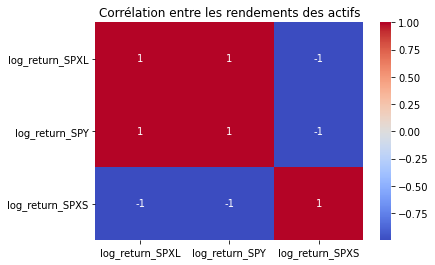

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0)
plt.title('Corrélation entre les rendements des actifs')
plt.show()

To comment on our results, we consider as a benchmark the 5-year annualized return of the S&P 500 on the same time interval (from 03/04/2020 to 02/04/2025), which is $\approx$ 17.9%. The two long ETFs (SPXL and SPY) have a positive return (respectively, $\approx$ 37% and $\approx$ 16.6% while the short ETF (SPXS) has a negative return($\approx$ -65.4%).

The returns have an intuitive and financial explanation, since the funds with a positive exposure to
the S&P 500 display a positive return, which is amplified for the 3x leveraged SPXL, while for the delta one SPY the return is similar to the one of the index, with a difference of around 1.3% related to the cost of the ETF (due to managing and distribution fees, small differences in the replication strategy). On the other hand, the 3x leveraged SPXS has a negative performance, in line with a short position in the S&P 500. As it will be discussed in the following questions, the performance of the leveraged ETFs is **NOT** $\approx 3 x Performance_{index}$.
As it can be visualized in the above correlation matrix, the long ETFs (SPXL and SPY) are positively
correlated with an almost perfect positive correlation of about 0.9985, and they both are negative correlated to the short ETF SPXS, with a very high negative correlation of about -0.9959 for SPXS and SPXL and -0.9966 for SPY and SPXL. 

Regarding volatility, both the S&P 500 and SPY display a standard deviation of $\approx$ 17.45%; since SPY is a delta one ETF that replicates S&P500, the fact that it has the same volatility and a similar annualized return it makes totally sense and reinforces the robustness of our calculations. As predictable, the annualized volatility for SPXL and SPXS is way higher due to their leverage, and it is $\approx$ 52%, which is $\approx 3 x Vol_{index}$ (to be more precise, SPXL voaltility $\approx$ 51.9%, while SPXS volatility $\approx$ 52.1%).

Having analyzed annualized returns and volatility, we can now pass to examine Sharpe Ratios. We use the annualized SOFR (2.77%) as the risk free rate for the computation.
The highest SR is the one of SPY, with a value of about 0.79, thanks to its low volatility and a return higher than the SOFR. At the second place we find SPXL with a SR of about 0.66, due to its extreme volatility: indeed, even if SPXL return is higher than SPY return, the excess return per unit of risk results lower than for the delta one ETF. Lastly, as obvious, there is SPXS, that with a negative annualized return brings its Sharpe Ratio in negative territory, with a value of about -1.30. Even though the high volatility brings the SR to values closer to 0 (since vol is at the denominator, higher volatility decreases the value of the numerator, which becomes less negative), the extreme negative return of SPXS heavily impacts on the final value of the SR. 

Passing to Skewness, all three ETFs have negative Skewness, with the highest one displayed by SPXL. This means that they have a higher probability of extreme negative returns, a finding that reconcilitaes with the idea of "Crashphobia" and the historical extreme drops in index values during financial (and non) crisis, which have been more frequent than sudden jumps in the opposite, positive direction, or in any case not that extreme. 

Lastly, analyzing Kurtosis we can have an idea of the tails of the distribution for the log-returns of the 3 ETFs: SPXS has a high Kurtosis (>3), and therefore its distribution is Leptokurtic (fat_tailed), which means that outliers are more probable to occur. SPXL has a moderate Kurtosis (~3), with moderate tails (Mesokurtic distribution, as Normal Distribution), and SPY has a low Kurtosis (<3), with thin-tails (Platykurtic distribution).  
*******************


**Question 5**. Explain why clients might believe that the following relationship
should hold:

$\frac{V_{T_2}(l)}{V_{T_1}(l)} \approx l \frac{S_{T_2}}{S_{T_1}} + (1 - l)$

We can rewrite the above equation as:   $l(\frac{S_{T_2}}{S_{T_1}} - 1) + 1$. 

From the above equation it is easier to intuitively explain what could be the client idea. Indeed, the client could think that the performance of the ETf with leverage $l$ should be approximately equal to the performance of the replicated index (in this case the S&P 500), given by $\frac{S_{T_2}}{S_{T_1}} - 1$ multiplied by $l$; the $-1$ and $+1$ in the equation are subtracted and added to correctly measure the rate of return of the strategy. 

Clients' idea is that a leveraged (by $l$) ETF's performance can be approximated by $l$ times the perfomance of the index - the approximation sign is used instead of the equality sign because the performance of the ETF would realistically be impacted by trading costs and/or managing and distribution fees. 
However, as it will be discussed in the following part of the project, client's assumption of a linear relationship between the ETF's perfomance and the index it replicates is not correct.  

***************


**Question 6**. Show that, in principle, between two dates $T_{2}$ and $T_{1}$ a better
prediction is given by:

$\frac{\tilde{V}_{T_2}(l)}{\tilde{V}_{T_1}(l)} \approx (\frac{\tilde{S}_{T_2}}{\tilde{S}_{T_1}})^l \exp(-\frac{1}{2}(l^2 - l)\hat{σ_{ 1,2}}^2 (T_{2} - T_{1}))$





First of all is useful to remember that the perfomance of leveraged ETFs is higher than the perfomance of the replicated index only if the ETFs' return is higher than the risk-free rate, which translates in a **positive excess return**. Indeed:

$\tilde{π}(α) = α^t \tilde{π}$

Where $\tilde{π}$ is the excess return which is  arandom variable ~ $N(\bar{π}, Σ)$, with $Σ$ being the variance covariance matrix, and $α$ is the proportion of the portfolio invested in the risky asset. When $α$ is higher than 1 (100% of the portfolio) then the portfolio is leveraged since it invets more than 100% in the risky asset, as in the case of the SPSX (3x leverage). Therefore, if $α=l=3$, we can then write the following relation between the ETF performance and the risky asset performance:

$rf + 3(\tilde{μ} - rf) ≥ \tilde{μ}$ ↔ $\tilde{μ} - rf ≥ 0$ ↔ $\tilde{μ} ≥ rf$ ↔ **positive excess return $(\tilde{π})$**

Where $rf$ is the risk-free rate (SOFR in this project) and $μ$ is the return of the risky asset (S&P 500 in this project). This is a first step that shows that the performance of a leveraged ETF depends on the risky asset return relation with the risk free rate, and it could be a starting point to explain how leveraged ETFs work in reality.

Keeping in mind this, we can examine the variation in the value of the ETF strategy ($dV_{t}$) to show that the equation in **Question 6** holds. With $α=l$ (leverage) we can write:

$dV_{t} = (ldV_{t})\frac{dS_{t}}{S_{t}} + (dV_{t} - lV_{t})\frac{dS_{t}}{S_{t}}$

Remembering that $dS_{t} = S_{t}(μ_{t}dt + σdW_{t})$ and $(1-l)rfdt = (1-l)\frac{{dB}_{t}}{{B}_{t}} $ we have:

$dV_{t} = V_{t}(lμ_{t}dt + lσdW_{t} + (1-l)rfdt)$, rearranging, we pass to:

$dV_{t} = V_{t}((rf + l(μ_{t} - rf))dt + lσdW_{t})$; applying $ln$ and using the quadratic variation of $V_{t}$, noted $d<V>_{t}$, we have:

$dlnV_{t} = \frac{1}{V}dV_{t} - \frac{1}{2V^2_{t}} d<V_{t}^2>$

Since $d<V>_{t} = V^2_{t}l^2 σ^2 dt$, we can rewrite the previous equation as:

$dlnV_{t} = [rf + l(μ_{t} - rf) - \frac{1}{2} l^2 σ^2]dt + lσdW_{t}$

We use the exponential properties, considering $(lnV_{t} - lnV_{0})$, to pass to:

$\frac{V_{t}}{V_{0}}=\exp[(rf + l(μ - rf) - \frac{1}{2} l^2 σ^2)t + lσW_{t}]$

$(\frac{S_{t}}{S_{0}})^l = \exp[l(μ_{t} - \frac{1}{2} σ^2)t + lσW_{t}]$

From this we can pass to:

$\frac{V_{t}}{V_{0}} = (\frac{S_{t}}{S_{0}})^l\exp[(rf(1-l) - \frac{1}{2} σ^2(l^2 - l))t]$

By switching $t$ with $T_2$, $0$ with $T_1$, $t$ with $(T_2 - T_1)$, $σ^2$ with $\hat{σ_{1,2}}^2$, $(\frac{\frac{{S}_{T_2}}{{B}_{T_2}}}{\frac{{S}_{T_1}}{{B}_{T_1}}})^l$ with $(\frac{\tilde{S}_{T_2}}{\tilde{S}_{T_1}})^l$, furthermore to have the correct formula we have to consider that r=0 and we can write:

$\frac{\frac{{V}_{T_2}}{{B}_{T_2}}}{\frac{{V}_{T_1}}{{B}_{T_1}}}= \frac{\tilde{V}_{T_2}(l)}{\tilde{V}_{T_1}(l)} \approx (\frac{\tilde{S}_{T_2}}{\tilde{S}_{T_1}})^l \exp[-\frac{1}{2}(l^2 - l)\hat{σ_{1,2}}^2 (T_{2} - T_{1})]$ 

These steps demonstrate that the equation in **Question 6** holds.


************************************************************************************************************************
It is possible to demonstrate the equation also throigh a different approach, as outlined below:

Starting from an autofinanced strategy:

$  \frac{dV_{t}}{V_{t}} = l \frac{dS_{t}}{S_{t}} + (1-l)\frac{dB_{t}}{B_{t}}$, and remembering that $(1-l)rfdt = (1-l)\frac{{dB}_{t}}{{B}_{t}} $

Given $l\frac{dS_{t}}{S_{t}} = ldlnS_{t} + \frac{l}{2}σ^2_{t}dt$ and $\frac{dV_{t}}{V_{t}} = dlnV_{t} + \frac{l^2}{2}σ^2_{t}dt$

Substituting $\frac{dS_{t}}{S_{t}}$ and $\frac{dV_{t}}{V_{t}}$

$dlnV_{t} = dlnS_{t}^l - \frac{1}{2}σ^2(l^2 - l)dt + (1-l)rfdt$

$dlnV_{t} = \frac{1}{V}dV_{t} - \frac{1}{2V^2_{t}} d<V_{t}^2>$

$dlnV_{t} = dlnS_{t}^l + ((1-l)rf - \frac{1}{2}σ^2(l^2 - l))dt$

In the time period [0, t], with 0 beign today

$(dlnV_{t} - dlnV_{0}) = lnS_{t}^l - lnS_{0}^l + \int_{0}^{t} ((1-l)rf_{t} - \frac{1}{2}σ_{t}^2(l^2 - l))ds$

And in conclusion we get:

$\frac{V_{t}}{V_{0}} = (\frac{S_{t}}{S_{0}})^l\exp[(1-l)rf - \frac{1}{2}σ_{t}^2(l^2 - l)(t-0)]$

If we set $rf = 0$, we have the equation in **Question 6**.

*********************************************************************




The exponential part of the equation representing the performance of the leveraged ETFs is  a correction factor depending on the value of volatility, leverage and risk-free rate, and it better replicate real-life scenarios in the movements of the . The first part of the equation is just the performance of the index to the power of l, due to properties of log-returns. In order to be always leveraged by a $l$ factor, the portfolio manager/managing company needs to trade based on the portfolio exposure to Gamma with important impacts on the performance of the portfolio. In the above formula, the correction factor replicates the effect of this trading impact on the leveraged ETF's perfomance. Due to convexity/concavity of the strategy, the Gamma will either be positive or negative, with consequences on the trading PnL and on return.

As a general overview, Trend-following are convex strategies (Gamma+, Theta-) and they require buying when prices increase and selling when prices decrease, with negative impacts on the trading P&L - with pontentially extreme impacts when there is leverage.   

On the other hand, Contrarian strategy are concave strategies(Gamma-, Theta+), and they require buying when prices decrease and selling when prices increase, with positive impacts on the trading P&L.

**Question 7**. Compute and plot the rolling 1 year estimated variance. Comment. What is the average trend due to leverage predicted by the formula for
each ETF? Comment

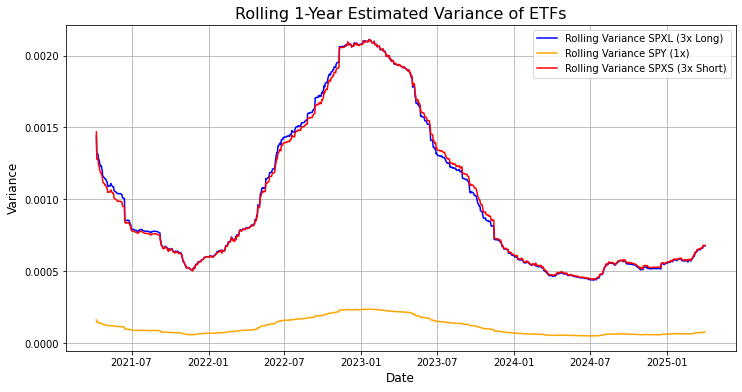

            Y_naive_SPXL  Y_predict_SPXL  Y_real_SPXL  Y_naive_SPY  \
2025-03-27      0.732084        0.834228     0.910695     0.920858   
2025-03-28      0.891467        0.988813     0.963822     0.938002   
2025-03-31      0.818150        0.915335     0.939383     0.929173   
2025-04-01      0.769247        0.868463     0.923082     0.924845   
2025-04-02      0.786560        0.884811     0.928853     0.926752   

            Y_predict_SPY  Y_real_SPY  Y_naive_SPXS  Y_predict_SPXS  \
2025-03-27       0.920858    0.920858      0.155425        0.386397   
2025-03-28       0.938002    0.938002      0.362759        0.456319   
2025-03-31       0.929173    0.929173      0.258427        0.419335   
2025-04-01       0.924845    0.924845      0.200000        0.400328   
2025-04-02       0.926752    0.926752      0.215318        0.405252   

            Y_real_SPXS  
2025-03-27     1.281525  
2025-03-28     1.212414  
2025-03-31     1.247191  
2025-04-01     1.266667  
2025-04-02     1.26156

In [104]:
rolling_window = 252

# Calculate rolling variance of daily log returns for each ETF
rolling_variance_SPXL = returns['log_return_SPXL'].rolling(window=rolling_window).var()
rolling_variance_SPY  = returns['log_return_SPY'].rolling(window=rolling_window).var()
rolling_variance_SPXS = returns['log_return_SPXS'].rolling(window=rolling_window).var()

# Plot the rolling variances
plt.figure(figsize=(12, 6))
plt.plot(rolling_variance_SPXL, label='Rolling Variance SPXL (3x Long)', color='blue')
plt.plot(rolling_variance_SPY,  label='Rolling Variance SPY (1x)', color='orange')
plt.plot(rolling_variance_SPXS, label='Rolling Variance SPXS (3x Short)', color='red')
plt.title('Rolling 1-Year Estimated Variance of ETFs', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Variance', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

#To have the rolling 1 - year returns, we need to 

# Compute Xti and Rti (1-year cumulative return ratios)
returns['Xti_SPXL'] = returns['price_SPXL'].shift(rolling_window) / returns['price_SPXL']
returns['Rti_SPXL'] = returns['perf_SOFR'].shift(rolling_window)  / returns['perf_SOFR']

returns['Xti_SPY']  = returns['price_SPY'].shift(rolling_window) / returns['price_SPY']
returns['Rti_SPY']  = returns['perf_SOFR'].shift(rolling_window) / returns['perf_SOFR']

returns['Xti_SPXS'] = returns['price_SPXS'].shift(rolling_window) / returns['price_SPXS']
returns['Rti_SPXS'] = returns['perf_SOFR'].shift(rolling_window) / returns['perf_SOFR']

# Set leverage levels
leverage_SPXL = 3
leverage_SPY  = 1
leverage_SPXS = -3

# Compute naive, predicted and real returns over the rolling window

# SPXL
returns['Y_naive_SPXL'] = leverage_SPXL * returns['Xti_SPXL'] + (1 - leverage_SPXL)
returns['Y_predict_SPXL'] = (returns['Xti_SPXL'] ** leverage_SPXL) * \
                            (returns['Rti_SPXL'] ** (1 - leverage_SPXL)) * \
                            np.exp(-0.5 * (leverage_SPXL**2 - leverage_SPXL) * rolling_variance_SPXL)
returns['Y_real_SPXL'] = returns['price_SPXL'].shift(rolling_window) / returns['price_SPXL']

# SPY
returns['Y_naive_SPY'] = leverage_SPY * returns['Xti_SPY'] + (1 - leverage_SPY)
returns['Y_predict_SPY'] = (returns['Xti_SPY'] ** leverage_SPY) * \
                           (returns['Rti_SPY'] ** (1 - leverage_SPY)) * \
                           np.exp(-0.5 * (leverage_SPY**2 - leverage_SPY) * rolling_variance_SPY)
returns['Y_real_SPY'] = returns['price_SPY'].shift(rolling_window) / returns['price_SPY']

# SPXS
returns['Y_naive_SPXS'] = leverage_SPXS * returns['Xti_SPXS'] + (1 - leverage_SPXS)
returns['Y_predict_SPXS'] = (returns['Xti_SPXS'] ** leverage_SPXS) * \
                            (returns['Rti_SPXS'] ** (1 - leverage_SPXS)) * \
                            np.exp(-0.5 * (leverage_SPXS**2 - leverage_SPXS) * rolling_variance_SPXS)
returns['Y_real_SPXS'] = returns['price_SPXS'].shift(rolling_window) / returns['price_SPXS']

# Show the final rows with all the calculated metrics
print(returns[['Y_naive_SPXL', 'Y_predict_SPXL', 'Y_real_SPXL', 
               'Y_naive_SPY',  'Y_predict_SPY',  'Y_real_SPY', 
               'Y_naive_SPXS', 'Y_predict_SPXS', 'Y_real_SPXS']].tail())


We compute the 1-year rolling average for the 3 ETFs, based on their log-returns, and we display the graphs to show their dynamics across time. As seen before, the variances of the 2 leveraged ETFs (SPXL and SPXS) are similar, and so is their dynamics and movements: they peak at the same time and overall they move together. SPY's variance, instead, is way lower and more linear, with less jumps and strong upwards/downwards trend.

Even if at different levels and with different intensity, the direction of volatility movements is the same for all the 3 ETFs. Also SPY's variance has a (small) peak around January 2022, the same period where SPXL and SPXS' variances peak. Moreover, all variances tends to lower levels when moving further frum Jan-2022, with a pickup at the extremities, around April 2020 on the left (more pronounced) and April 2025 on the right. 

The model predicts an extreme impact of the leverage on variance during periods of higher volatility, with the overall trend of SPXL and SPXS following SPY's vol movements, but at higher and more extreme levels. Investing in leveraged ETFs exposes to high-volatility especially when markets is sorrounded by uncertainty and instability, heavily impacting on the risk-return payoff, as we have seen through the Sharpe Ratio values computed above (the highest SR value it the one of SPY, which has the lowest predicted variance). 

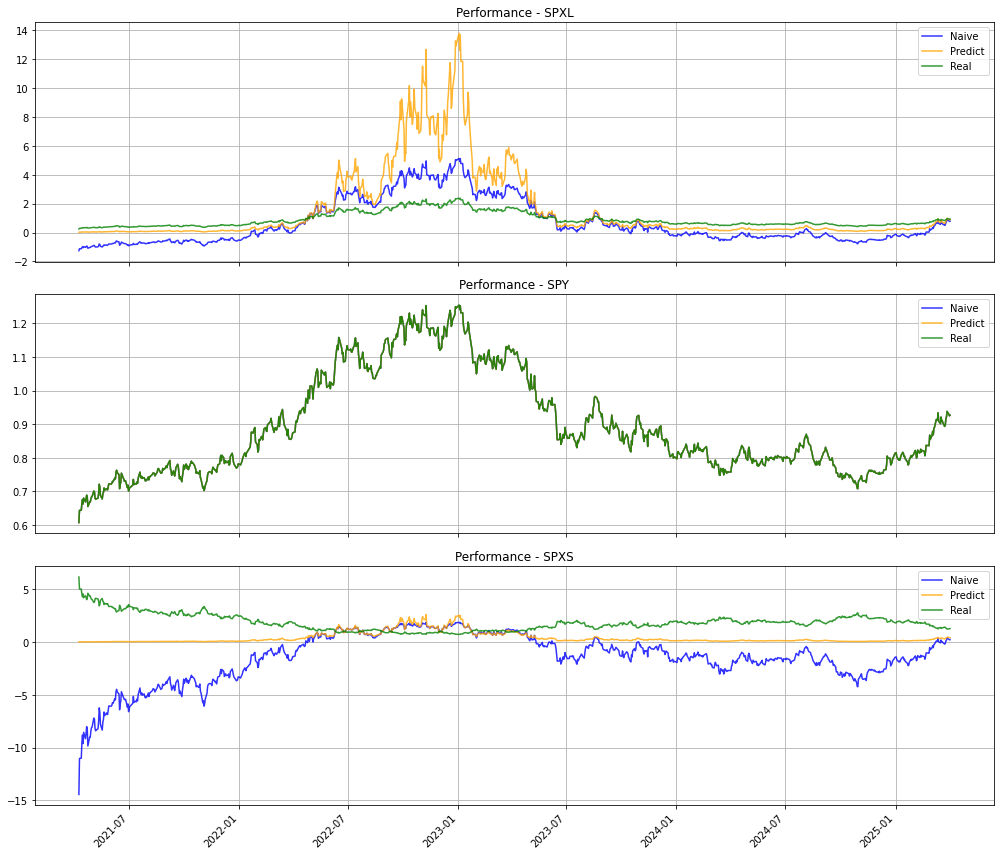

In [105]:
import matplotlib.pyplot as plt

# Configuration
tickers = ['SPXL', 'SPY', 'SPXS']
prefixes = ['Y_naive', 'Y_predict', 'Y_real']
colors = {'Y_naive': 'blue', 'Y_predict': 'orange', 'Y_real': 'green'}
labels = {'Y_naive': 'Naive', 'Y_predict': 'Predict', 'Y_real': 'Real'}

#We create the figure
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

for i, ticker in enumerate(tickers):
    cols = [f"{prefix}_{ticker}" for prefix in prefixes]
    
    # We create a dataframe with only the useful columns
    temp_df = returns[cols].dropna()  # We delete the lines with NaN
    
    # We check if it remains data
    if not temp_df.empty:
        # And we plot.
        for prefix in prefixes:
            col = f"{prefix}_{ticker}"
            axes[i].plot(temp_df.index, temp_df[col],
                        label=labels[prefix],
                        color=colors[prefix],
                        alpha=0.8)
    
    axes[i].set_title(f'Performance - {ticker}')
    axes[i].legend()
    axes[i].grid(True)
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

The charts for both SPXL (3x long) and SPXS (3x short) demonstrate how leverage amplifies not only returns but also volatility drag. While the naive prediction (simple 3x multiplication) systematically overestimates the over performance (for bull markets) and under performance (for bear markets), the adjusted prediction (incorporating the $exp^{-0.5(l^{2}-l)\sigma^{2}}$ term) better approximates reality by accounting for volatility decay. However, even the adjusted prediction isn't perfect because: (1) it assumes continuous compounding, while ETFs rebalance daily; (2) it ignores transaction costs and management fees; (3) real-world volatility clusters and tail risks aren't fully captured by historic $σ²$. The symmetric drag ($l²-l$ which equally impacts the leveraged ETFs for ±3x) highlights how leverage creates path-dependent returns where volatility is multiplicative rather than additive, making long-term performance diverge from intuitive expectations. The formula provides a directional correction but remains an approximation of the complex realities of leveraged ETFs.

The formula-based prediction (orange) sometimes deviates more from reality (green) than the naive linear projection (blue), which seems counterintuitive given the theoretical adjustment for volatility. The formula's underperformance stems from its idealized assumptions: it overcorrects for volatility by treating it as smooth $(exp(−0.5(l²−l)σ²))$ while ignoring real-world complexities like daily ETF rebalancing, which amplifies path-dependent decay during market turbulence (e.g., crashes). It also omits costs (management fees, transaction slippage) and fails to capture asymmetric market behavior—crashes hit short ETFs (SPXS) harder than rallies benefit longs (SPXL), skewing outcomes beyond the symmetric l²−l adjustment. This explains why SPXS doesn't perfectly hedge SPXL. Moreover, the gap between theory and practice makes the formula's predictions diverge further from reality than even naive estimates under certain regimes.

There are no necessary comments on the delta one ETF. The naive, predicted and real formula are exactly the same. So we have only one curve on the graph. 

To be more specific on the third graph, at the beginning of the the anlayzed period we observe a large gap between the naive and real performances. This can be confronted with the graph in **Question 3**. Since S&P 500 skyrocked during the second part of 2020, the performance of SPXS computed with the naive formula strongly underestimates the real return of the ETF. Without the correction factor which is present in the predicted performance, supposing that there is a linear relation betweens SPXS and S&P 500 generates this unrealistic naively predicted performance. 

**Question 8**

R^2 Values:
SPXL vs Predict: 0.8807, vs Naive: 1.0000
SPY vs Predict: 1.0000, vs Naive: 1.0000
SPXS vs Predict: 0.4758, vs Naive: 1.0000


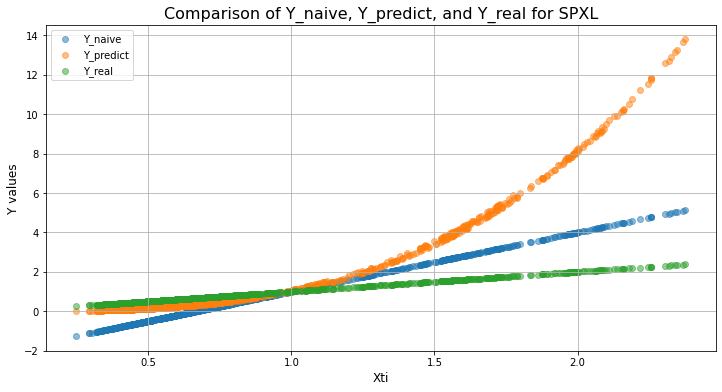

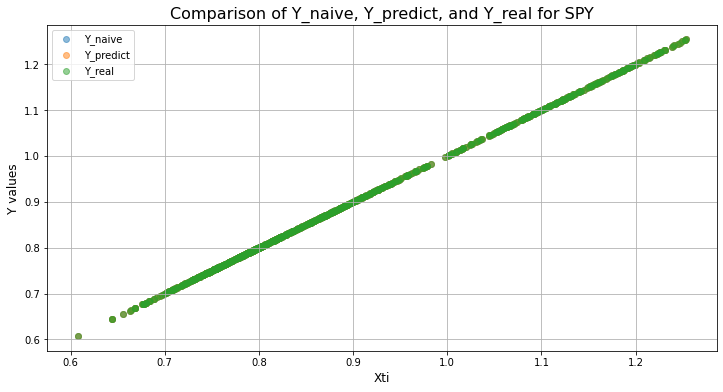

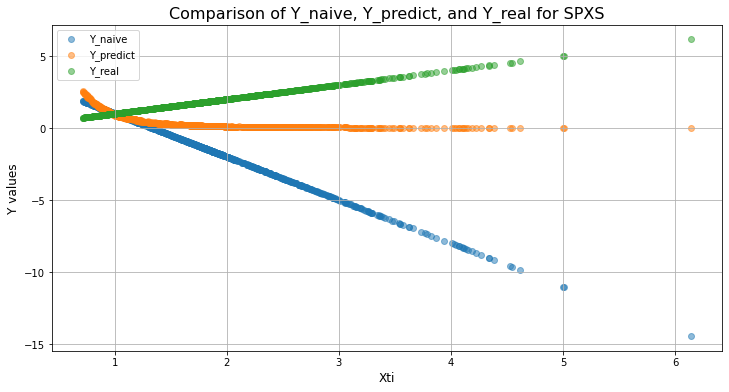

In [106]:
# Function to compute R^2 for a regression model
def compute_r_squared(y_true, y_pred):
    # Fit the model
    model = sm.OLS(y_true, sm.add_constant(y_pred)).fit()
    return model.rsquared

# Calculate R^2 values for each ETF
r_squared_SPXL_predict = compute_r_squared(returns['Y_real_SPXL'].dropna(), returns['Y_predict_SPXL'].dropna())
r_squared_SPXL_naive = compute_r_squared(returns['Y_real_SPXL'].dropna(), returns['Y_naive_SPXL'].dropna())

r_squared_SPY_predict = compute_r_squared(returns['Y_real_SPY'].dropna(), returns['Y_predict_SPY'].dropna())
r_squared_SPY_naive = compute_r_squared(returns['Y_real_SPY'].dropna(), returns['Y_naive_SPY'].dropna())

r_squared_SPXS_predict = compute_r_squared(returns['Y_real_SPXS'].dropna(), returns['Y_predict_SPXS'].dropna())
r_squared_SPXS_naive = compute_r_squared(returns['Y_real_SPXS'].dropna(), returns['Y_naive_SPXS'].dropna())

# Print R^2 values
print("R^2 Values:")
print(f"SPXL vs Predict: {r_squared_SPXL_predict:.4f}, vs Naive: {r_squared_SPXL_naive:.4f}")
print(f"SPY vs Predict: {r_squared_SPY_predict:.4f}, vs Naive: {r_squared_SPY_naive:.4f}")
print(f"SPXS vs Predict: {r_squared_SPXS_predict:.4f}, vs Naive: {r_squared_SPXS_naive:.4f}")

# Plotting Y_naive, Y_predict, and Y_real as functions of Xti for each ETF
for etf in ['SPXL', 'SPY', 'SPXS']:
    plt.figure(figsize=(12, 6))
    
    # Plot naive values
    plt.scatter(returns[f'Xti_{etf}'], returns[f'Y_naive_{etf}'], label='Y_naive', alpha=0.5)
    
    # Plot predicted values
    plt.scatter(returns[f'Xti_{etf}'], returns[f'Y_predict_{etf}'], label='Y_predict', alpha=0.5)
    
    # Plot real values
    plt.scatter(returns[f'Xti_{etf}'], returns[f'Y_real_{etf}'], label='Y_real', alpha=0.5)

    plt.title(f'Comparison of Y_naive, Y_predict, and Y_real for {etf}', fontsize=16)
    plt.xlabel('Xti', fontsize=12)
    plt.ylabel('Y values', fontsize=12)
    plt.legend()
    plt.grid()
    plt.show()

Thanks to this figure we can see that $R^2$ of the Y_Naive is always 1. This is perfectly logical knowing that Y_naive is simply an affine function of $X_{ti}$ , so the OLS method perfectly fit the two samples. 

What is surprising is that Y_predict never succeed in fitting returns when it comes to big jumps. This is due to the fact that the model considers an historical volatitlity over 1-year period. It cannot predict any sudden rise of the underlying if the 1-year past returns were low. This underlines what we discussed in the previous question: the predict model is path dependant on realized volatility in the past (in our case over 1-year period). 

From our analysis, it results that $R^2$ is higher for SPXL ($\approx0.88$) than for SPXS($\approx0.47$), and this reconciliates with the last consideration we made in **Question 7**, and it is in line with the graph showed above. 

**Question 9**. Comment. Is the naive prediction good? Is the theoretical
description good? How would you present this to a non-sophisticated investor? Would you recommend these products?

The naive prediction model assumes a linear relationship between the leveraged ETF and the underlying index. Specifically, it presumes that the return of the ETF is simply a multiple of the index return, adjusted by the leverage factor. While this might seem intuitive and works reasonably well over very short horizons or in low-volatility environments, it quickly breaks down when applied over longer periods. It fails to capture the effects of volatility drag — the compounding effect of daily returns that can significantly erode performance even when the underlying asset trends upward.

In contrast, the theoretical model incorporates an adjustment for volatility through a decay term that reflects the long-term impact of compounding in the presence of fluctuations. This is especially important for leveraged ETFs, where the squared leverage factor amplifies the adverse effects of market volatility. The predicted return from this model generally shows a better alignment with the actual returns observed in the data, but it can strongly deviates particularly in periods of heightened market turbulence, even more than the naive prediction. 

To explain this concept to a non-sophisticated investor, we could say: leveraged ETFs are designed to multiply the daily return of an index — not its long-term return. So, while the S&P 500 might go up 10% over a year, a 3x leveraged ETF like SPXL may not go up 30%. In fact, it might go up less, or even lose value, depending on how volatile the market was during that year. This is due to the compounding effects of daily returns, which are not as simple as multiplying a yearly return by 3. Volatility chips away at returns over time — a phenomenon that naive expectations ignore, but which the theoretical formula accounts for.

From a recommendation standpoint, these products can make sense for short-term tactical trading, where the objective is to capture brief directional movements in the market. However, for long-term investing, they are generally unsuitable unless the investor thoroughly understands the risks and has a strategy in place for managing them. Without this, holding leveraged ETFs over extended periods can lead to unexpected — and often disappointing — results.

**Question 10**. Instead of buying a Direxion ETF, your bank considers to implement the leveraged strategy at home. They ask you to simulate the strategy
with a leverage equal to 3. Compare the results with the ETF and with the
prediction. Comment.

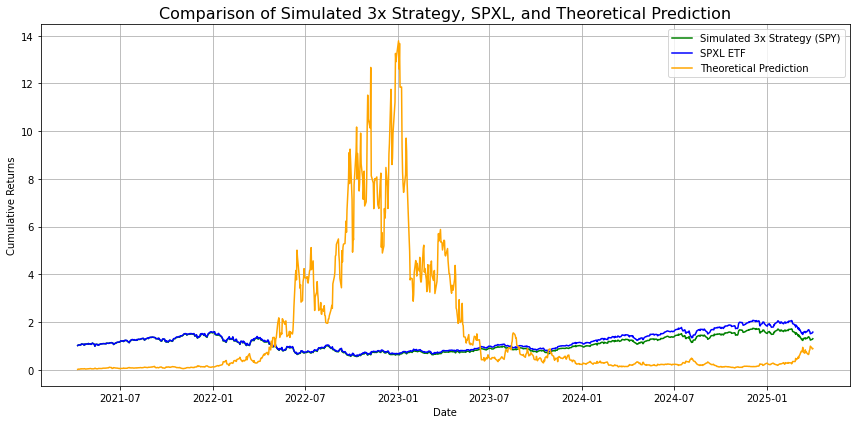

Final Cumulative Return of Simulated Strategy: 1.3002
Final Cumulative Return of SPXL: 1.5776
Final Cumulative Return of Theoretical Prediction: 0.8848


In [107]:
rolling_window = 252
#For predict daily return we need to have an historical rolling window

Set leverage
leverage = 3

#Compute daily returns from log returns
returns['daily_return_SPY'] = returns['price_SPY'] / returns['price_SPY'].shift(1)
returns['daily_return_SPXL'] = returns['price_SPXL'] / returns['price_SPXL'].shift(1)
#Let's consider the 1 year predictive ratio used in question 7 and 8 for prediction on SPXL


#Compute borrowing cost from SOFR (must align index properly)
returns['borrowing_cost'] = df_SOFR['index'].pct_change().fillna(0) * leverage

#Simulate leveraged strategy returns
returns['leveraged_return'] = (leverage * (returns['daily_return_SPY']-1)) - returns['borrowing_cost']

#Compute cumulative returns
returns['cumulative_leveraged'] = (1 + returns['leveraged_return'].iloc[rolling_window:]).cumprod()
returns['cumulative_SPXL'] = (returns['daily_return_SPXL'].iloc[rolling_window:]).cumprod()
returns['cumulative_predicted'] = returns['Y_predict_SPXL']

#Drop rows with missing values
returns_clean = returns.dropna(subset=[
    'cumulative_leveraged',
    'cumulative_SPXL',
    'cumulative_predicted'
])

#Check if returns_clean is not empty before plotting or printing
if not returns_clean.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(returns_clean.index, returns_clean['cumulative_leveraged'], label='Simulated 3x Strategy (SPY)', color='green')
    plt.plot(returns_clean.index, returns_clean['cumulative_SPXL'], label='SPXL ETF', color='blue')
    plt.plot(returns_clean.index, returns_clean['cumulative_predicted'], label='Theoretical Prediction', color='orange')

    plt.title('Comparison of Simulated 3x Strategy, SPXL, and Theoretical Prediction', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("Final Cumulative Return of Simulated Strategy:", round(returns_clean['cumulative_leveraged'].iloc[-1], 4))
    print("Final Cumulative Return of SPXL:", round(returns_clean['cumulative_SPXL'].iloc[-1], 4))
    print("Final Cumulative Return of Theoretical Prediction:", round(returns_clean['cumulative_predicted'].iloc[-1], 4))
else:
    print("Warning: No data available to plot or print final returns. Check inputs and alignment.")


For the in-house leveraged strategy we computed its performance by proxying S&P 500 return through SPY. Indeed, a pure replication of the S&P 500 would be costly and difficult to replicate in reality, in particular when considering potential rebalances of the index and tarding costs (securities removed from index, new securities added, different proportions for existing members). The idea behind the in-house strategy is to go long 3x the SPY, which should approximate a 3X long position in the S&P 500. 

Comparing the return of the in-house simulated strategy, SPXL, and the prediction, the firts thing to consider is that the best option would be to simply buy the ETF, since its performance is higher than the one of the in-house strategy consisting in going long the S&P 500 (proxied by SPY) with leverage 3x. The prediction is too strongly impacted by high volatility periods, bringing returns to extreme values and implying sudden jumps in the return-path. 

The in-house strategy does not deviates from SPXL until 2023, and then increasingly underperform the leveraged ETF (even accounting for ETF's costs). Moreover, considering the costs in managing the in-house strategy and the expertise needed, it does not seem the best option for the bank, that would have the same exposure by simply buying the SPXL. The theoretical prediction is unreliable for either the SPXL and in-house leverage strategy, especially in period of high volatility. 

In conclusion, if well aware of the high exposure to volatility of leveraged ETFs, and that they replicate daily index perfomances and **NOT** annualized or cumulative ones, the bank, and more in general an investor, should opt for the SPXL ETF to gain a leverage exposure to S&P 500, especially when interested in doing it over a short-time horizon. 